Running variant=logic, regime=trend, lr=0.01


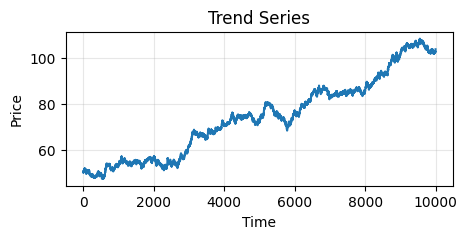

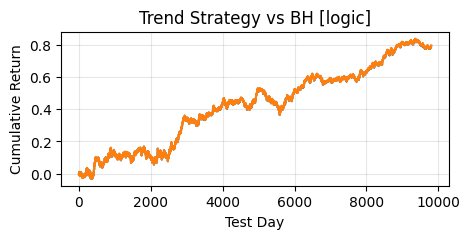

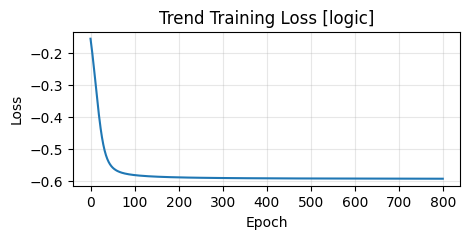

Running variant=logic, regime=switch, lr=0.001


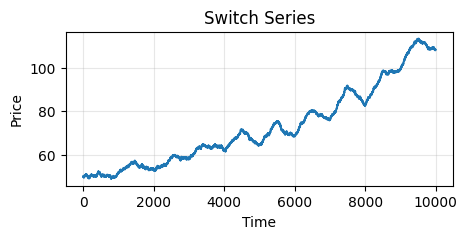

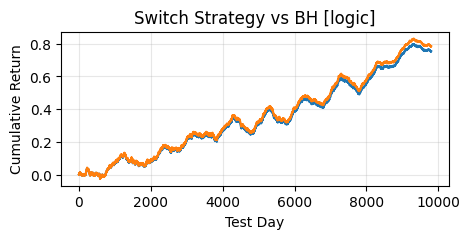

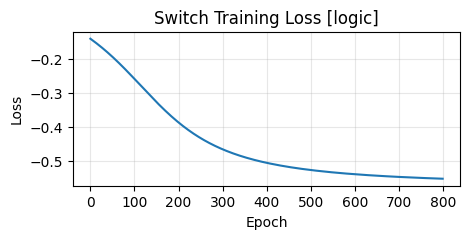

Running variant=logic, regime=flat, lr=0.01


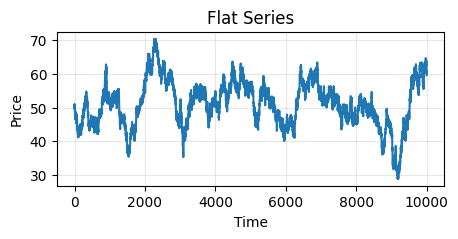

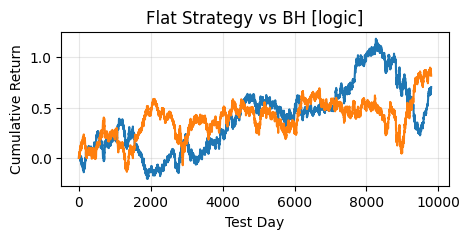

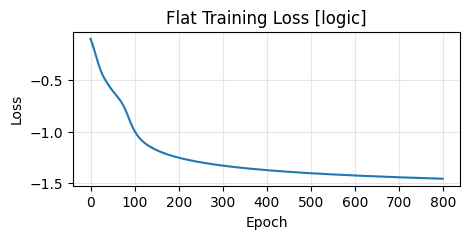

Running variant=logic+feature, regime=trend, lr=0.01


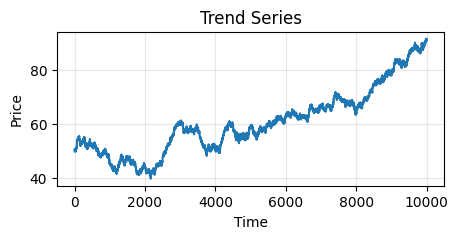

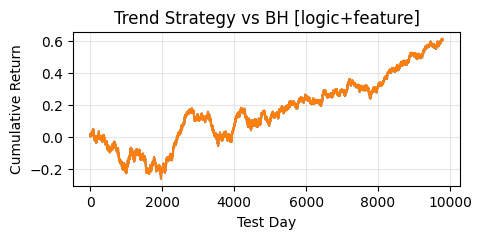

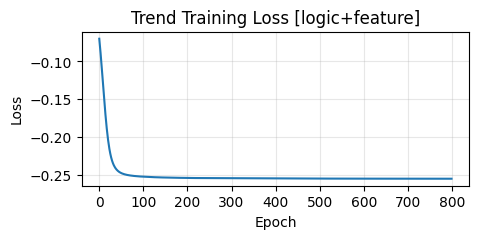

Running variant=logic+feature, regime=switch, lr=0.001


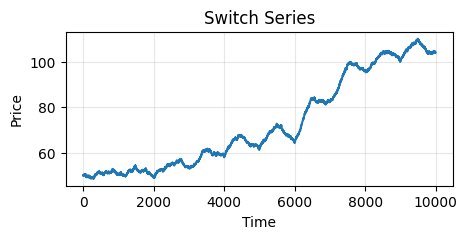

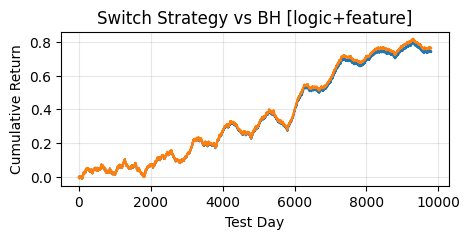

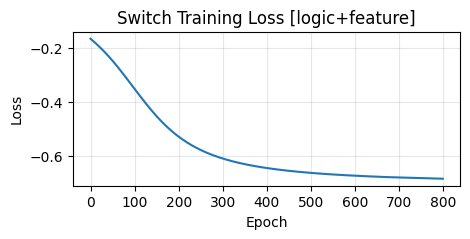

Running variant=logic+feature, regime=flat, lr=0.01


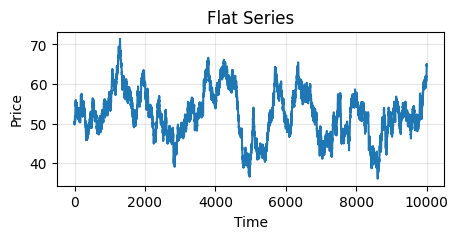

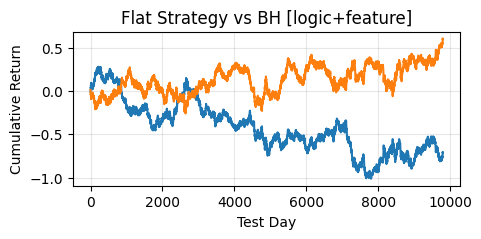

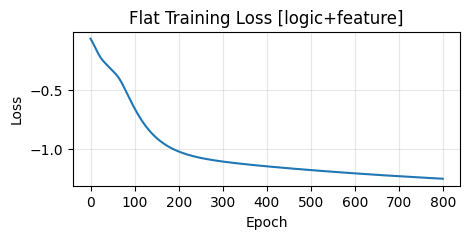

Running variant=all, regime=trend, lr=0.01


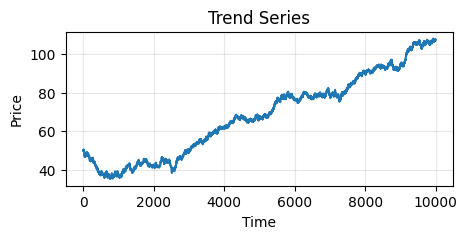

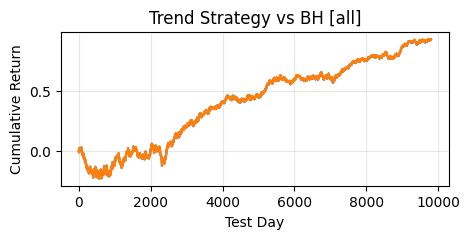

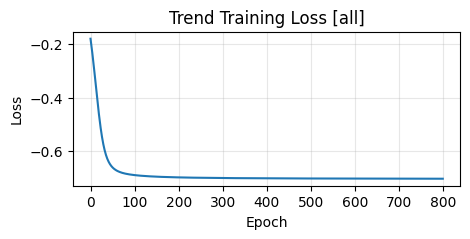

Running variant=all, regime=switch, lr=0.001


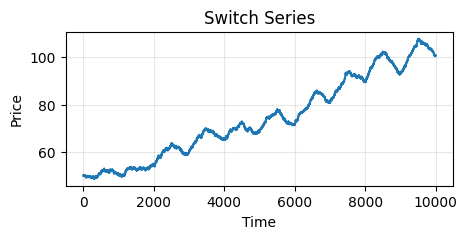

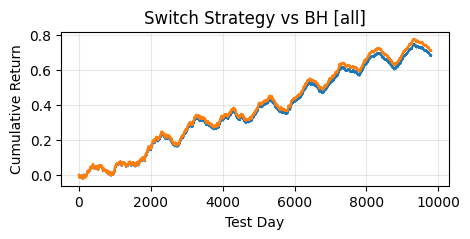

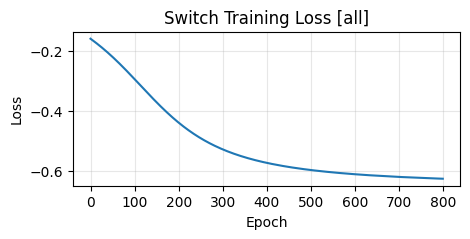

Running variant=all, regime=flat, lr=0.01


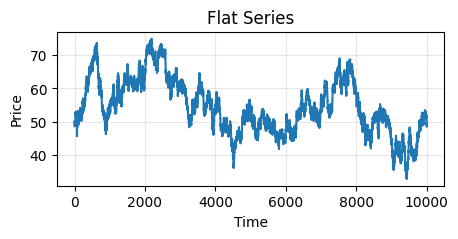

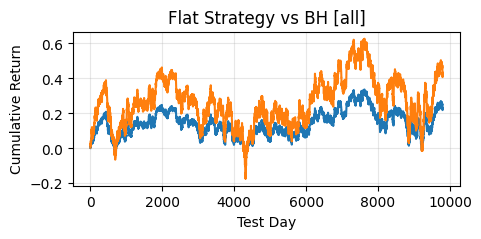

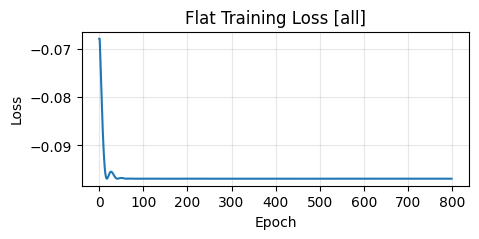

Variant,all,logic,logic+feature
Regime,,,
flat,0.072912,0.116299,-0.124098
switch,0.787439,0.843975,0.798759
trend,0.434997,0.445496,0.278065


In [1]:
import pandas as pd
from evaluate import evaluate_synthetic

# Hyperparams
window_long, window_short = 200, 50
variants  = ['logic','logic+feature','all']
regimes   = ['trend','switch','flat']
beta      = 10.0
epochs    = 800

results = []
for variant in variants:
    for regime in regimes:
        lr = 0.001 if regime=='switch' else 0.01
        print(f"Running variant={variant}, regime={regime}, lr={lr}")
        sr = evaluate_synthetic(
            regime=regime,
            window_short=window_short,
            window_long=window_long,
            variant=variant,
            beta=beta,
            lr=lr,
            epochs=epochs
        )
        results.append((variant, regime, sr))

# Build and display the test‐Sharpe table
df = pd.DataFrame(results, columns=['Variant','Regime','Sharpe']) \
       .pivot(index='Regime', columns='Variant', values='Sharpe')
display(df)
